In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import math
import random 

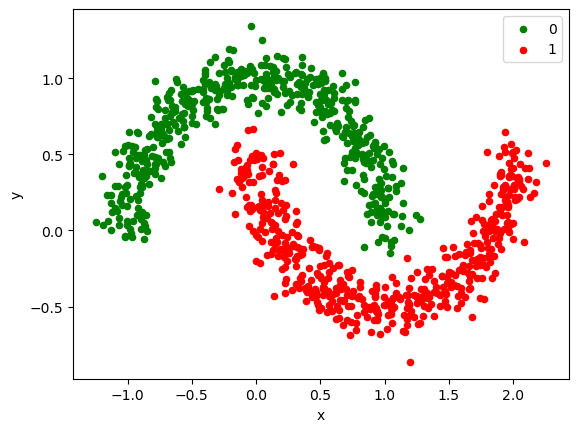

In [2]:
X,y = make_moons(n_samples=1000,noise=0.1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

data_set = pd.DataFrame(dict(x=X[:,0],y= X[:,1], label= y))
colors ={0:'green' , 1:'red'}
fig, ax = plt.subplots()
inputs = data_set.groupby('label')
for key , label in inputs:
    label.plot(ax=ax , kind = 'scatter' , x= 'x' ,y='y' , label=key ,color=colors[key])
plt.show()

In [3]:
def square_error_loss(y_true, y_pred):
    return (y_true - y_pred) ** 2

def mean_square_error(y_true, y_pred):
    return np.sum(square_error_loss(y_true, y_pred)) / len(y_pred)

def sig_af(z):
    return 1/(1 + np.exp(-z))

def tanh_af(z):
    return np.tanh(z)

In [4]:
def set_params(n_input,n_hidden,n_out,hidden_af,output_af):
    
    W_hide = np.random.randn(n_hidden, n_input+1) 
    W_out = np.random.randn(n_out, n_hidden+1) 
    delta_W_hide_ago = np.zeros((n_hidden, n_input+1))
    delta_W_out_ago = np.zeros((n_out, n_hidden+1))
    dw_out = np.zeros((n_out,n_hidden+1))
    dw_hide = np.zeros((n_hidden,n_input+1))
    
    parameters = {"W_hide": W_hide,
                  "W_out":W_out,
                  "delta_W_hide_ago":delta_W_hide_ago,
                  "delta_W_out_ago":delta_W_out_ago,
                  "act_func_hide":hidden_af, 
                  "act_func_out":output_af}
    
    return parameters

In [5]:
def forward_propagation(X, parameters):
    
    X_b = np.append(np.ones((X.shape[0],1)),X,axis=1)
    z_hide = np.dot(parameters["W_hide"],X_b.T)
    
    if parameters['act_func_hide'] =='tanh':
        A_hide = tanh_af(z_hide)
    else :
        A_hide = sig_af(z_hide)
        
    A_hide_b = np.append(np.ones((1,X.shape[0])),A_hide,axis=0)
    z_out = np.dot(parameters["W_out"],A_hide_b)
    
    if parameters['act_func_out']=='liner':
        A_out = z_out
    elif parameters['act_func_out']=='tanh':
        A_out = tanh_af(z_out)
    else:
        A_out = sig_af(z_out)
        
    prev_params = {"z_hide": z_hide,
                   "A_hide": A_hide,
                   "z_out": z_out,
                   "A_out": A_out}
    
    return A_out,prev_params

In [6]:
def backward_propagation(parameters,prev_params, X, Y):
    
    m = X.shape[0]
    X = np.append(np.ones((X.shape[0],1)),X,axis=1)
    dL = -(Y-prev_params['A_out'])
    
    
    if parameters['act_func_hide'] =='tanh':
        dz_out = 1-np.power(prev_params['A_out'],2)
    else:
        dz_out = prev_params['A_out']*(1.0-prev_params['A_out'])
    dw_out = (1/m) * (np.dot(dL*dz_out,np.append(np.ones((1,X.shape[0])),prev_params['A_hide'],axis=0).T))
    
    
    
    if parameters['act_func_out']=='liner':
        dz_hide = prev_params['A_hide']
    elif parameters['act_func_out']=='tanh':
        dz_hide = 1-np.power(prev_params['A_hide'],2)
    else:
        dz_hide = prev_params['A_hide']*(1.0-prev_params['A_hide'])

        
    buffer = dL*np.dot(parameters['W_out'][:,1:].T,dz_out)
    buffer = buffer * dz_hide
    dw_hide = (1/m) * np.dot(buffer,X)
    grads = {"dw_out": dw_out,
             "dw_hide": dw_hide,}
    
    return grads

In [7]:
def update_parameters(parameters, grads):
    dw_hide = grads["dw_hide"]
    dw_out = grads["dw_out"]
    W_hide = parameters["W_hide"]
    W_out = parameters["W_out"]
    
    delat_W_hide = np.power(parameters['reduction_factor'],
    parameters['epoch']) * parameters['learning_rate'] * dw_hide + parameters['gama'] * parameters["delta_W_hide_ago"]
    
    
    delat_W_out = np.power(parameters['reduction_factor'],
    parameters['epoch']) * parameters['learning_rate'] * dw_out + parameters['gama'] * parameters["delta_W_out_ago"]
    
    
    W_hide = W_hide - delat_W_hide
    W_out = W_out - delat_W_out
    parameters["delta_W_hide_ago"] = delat_W_hide
    parameters["delta_W_out_ago"] = delat_W_out
    parameters['W_hide'] =  W_hide
    parameters['W_out'] =  W_out
    return parameters

In [8]:
def get_predict(parameters, X):
    
    A_out , prev_params = forward_propagation(X,parameters)
    for elm in A_out:
        elm = (elm > 0.5)
        
    return (elm *1)

def get_accurecy(parameters,X,y):
    
    true_detect = 0
    
    for index,x in enumerate(X):
        if get_predict(parameters,X[[index]]) == y[index]:
            true_detect += 1
            
    return true_detect/X.shape[0]

In [9]:
def create_nn_model(X, y , nerun_hide,nerun_out, epochs = 20,act_hide='sig',
             act_out='sig',mode='online', print_cost=False ,
             learning_rate = 0.3,threshold=0.999,reduction_factor=1,gama=0):
    
    nerun_input = X.shape[1]
    parameters = set_params(nerun_input,nerun_hide,nerun_out,act_hide,act_out)
    parameters['learning_rate'] = learning_rate
    parameters['threshold'] = threshold
    parameters['reduction_factor'] = reduction_factor
    parameters['epochs'] = epochs
    parameters['gama'] = gama
    parameters_max_mse = parameters
    cost=math.inf
    mse_i=[]
    
    
#      Online Learning mode           

    if mode == 'online':
        for i in range(parameters['epochs']):
            parameters['epoch'] = i
            for j in range(X.shape[0]):
                index = random.sample(range(X.shape[0]), 1)
                A_hide, prev_params = forward_propagation(X[index],parameters)
                grads = backward_propagation(parameters, prev_params, X[index], y[index])
                parameters = update_parameters(parameters, grads)
            
            cost = mean_square_error(A_hide, y,)
            mse_i.append(cost)
            if mean_square_error(A_hide, y,)< cost:    
                parameters_max_mse = parameters
            a = get_accurecy(parameters,X,y)
            if a >= parameters['threshold']:
                break;
            if print_cost:
                print ("Cost after iteration %i: %f" % (i, cost))
                
                
#      Batch Learning mode           
    else:
        for i in range(parameters['epochs']):
            parameters['epoch'] = i
            A_hide, prev_params = forward_propagation(X,parameters)
            grads = backward_propagation(parameters, prev_params, X, y)
            parameters = update_parameters(parameters , grads )
            cost = mean_square_error(A_hide, y,)
            mse_i.append(cost)
            if mean_square_error(A_hide, y,)< cost:
                parameters_max_mse=parameters
            a = get_accurecy(parameters,X,y)
            if a >= parameters['threshold']:
                    break;
            if print_cost: 
                print ("Cost after iteration %i: %f" % (i, cost))
                
                
    plt.figure()
    plt.plot(np.arange(0, parameters['epoch']+1,1, dtype = int), mse_i)
    plt.xlabel('Itteration')
    plt.ylabel('Squared Error')
    plt.show()
    return parameters_max_mse

In [10]:
def draw_decision_boundary(parameters, X, Y):
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    h = 0.01
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    Z = get_predict(parameters, grid_points)
    Z = Z.reshape(xx.shape)
    
    
    cs = plt.contourf(xx,yy,Z,colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
    cs.cmap.set_over('red')
    cs.cmap.set_under('green')
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="gray")
    plt.ylabel('x2')
    plt.xlabel('x1')
    cs.changed()

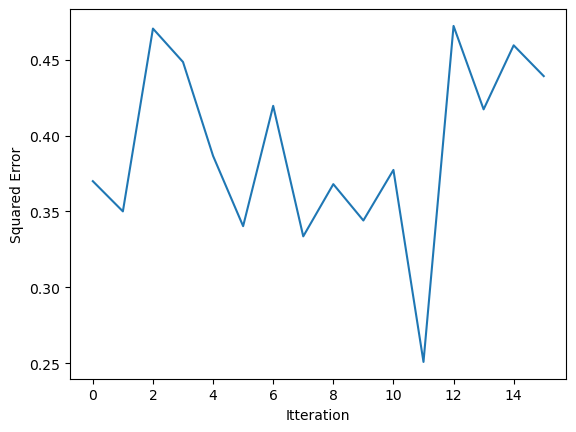

In [45]:
sig_sig_online_Fixedlearning = create_nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=180,
                                   act_hide='sig',act_out='sig',mode='online',print_cost=False,
                                   learning_rate =0.61)

Accuracy = 1.0


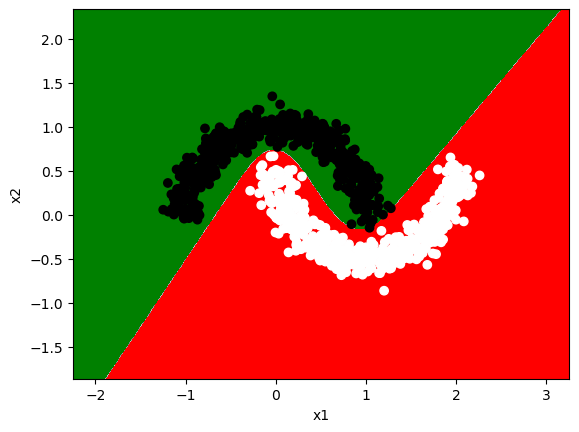

In [46]:
draw_decision_boundary(sig_sig_online_Fixedlearning, X, y)
print(f"Accuracy = {get_accurecy(sig_sig_online_Fixedlearning,x_test,y_test)}")

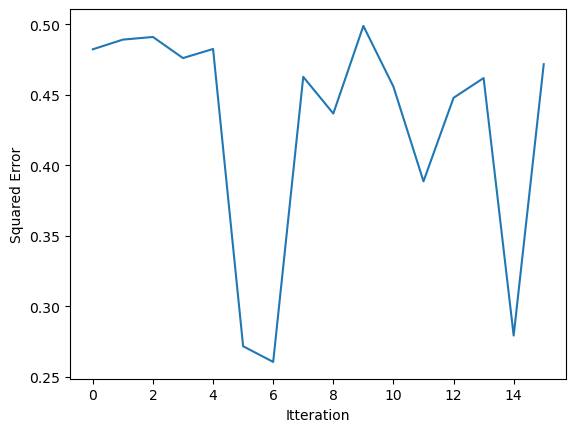

In [43]:
sig_sig_online_mode_Adaptivelearning = create_nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=180,
                                     act_hide='sig',act_out='sig',mode='online',print_cost=False,
                                     learning_rate = 6, reduction_factor = 0.9)


Accuracy = 1.0


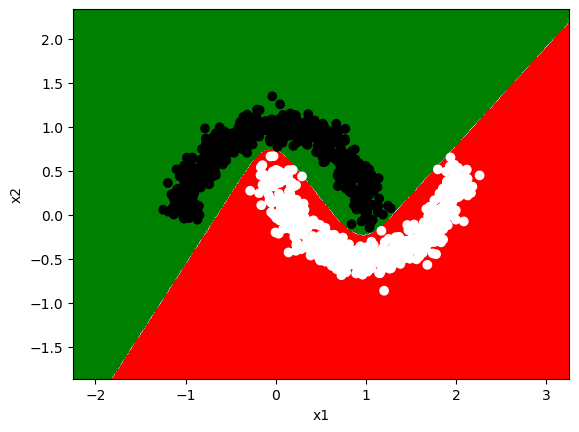

In [44]:
draw_decision_boundary(sig_sig_online_mode_Adaptivelearning, X, y)
print(f"Accuracy = {get_accurecy(sig_sig_online_mode_Adaptivelearning,x_test,y_test)}")

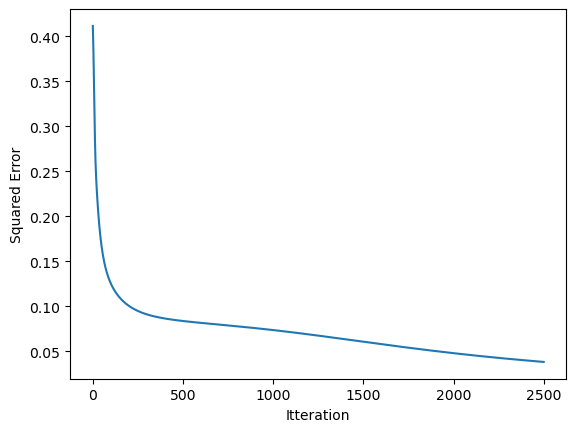

In [41]:
sig_sig_batch_mode_Fixedlearning = create_nn_model(x_train, y_train,nerun_hide=8,nerun_out=1,epochs=2500,
                                   act_hide='sig',act_out='sig',mode='batch',print_cost=False,
                                   learning_rate =0.93)

Accuracy = 0.96


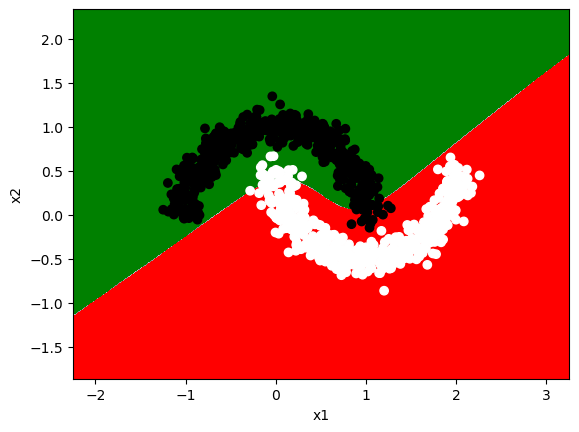

In [42]:
draw_decision_boundary(sig_sig_batch_mode_Fixedlearning, X, y)
print(f"Accuracy = {get_accurecy(sig_sig_batch_mode_Fixedlearning,x_test,y_test)}")

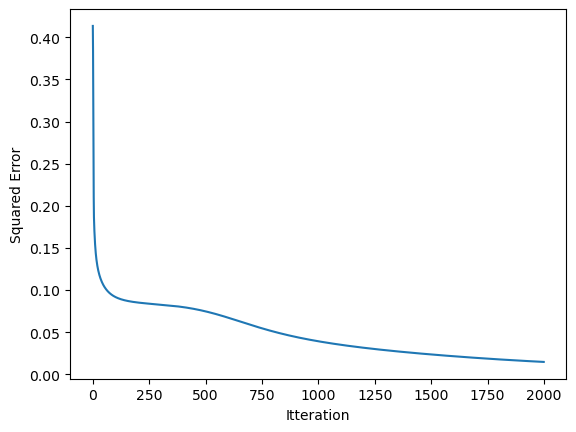

In [47]:
sig_sig_batch_mode_Adaptivelearning = create_nn_model(x_train, y_train,nerun_hide=8,nerun_out=1,epochs=2000,
                                      act_hide='sig',act_out='sig',mode='batch',print_cost=False,
                                      learning_rate =3, reduction_factor = 0.999999)

Accuracy = 0.99


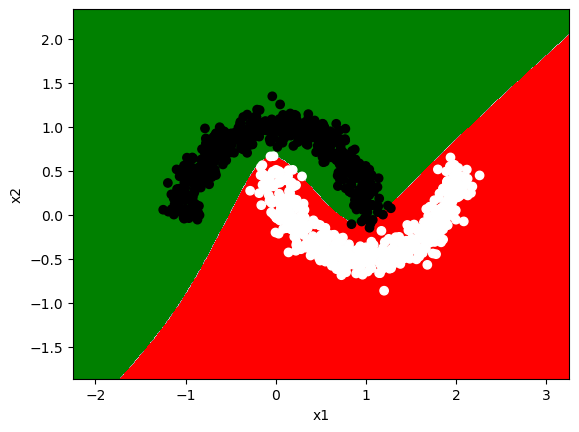

In [48]:
draw_decision_boundary(sig_sig_batch_mode_Adaptivelearning, X, y)
print(f"Accuracy = {get_accurecy(sig_sig_batch_mode_Adaptivelearning,x_test,y_test)}")

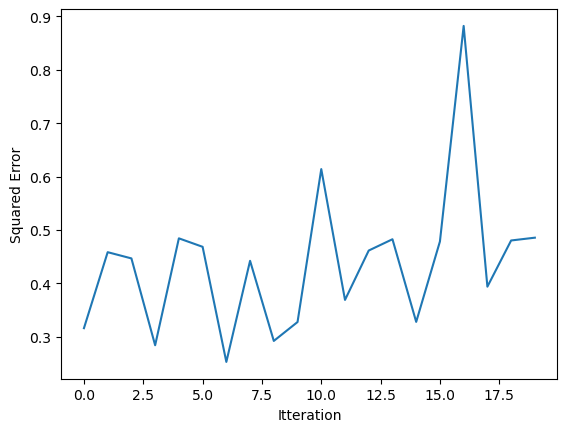

In [37]:
tanh_tanh_online_mode_Fixedlearning = create_nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=200,
                                      act_hide='tanh',act_out='tanh',mode='online',print_cost=False,
                                      learning_rate = 0.3)

Accuracy = 0.9966666666666667


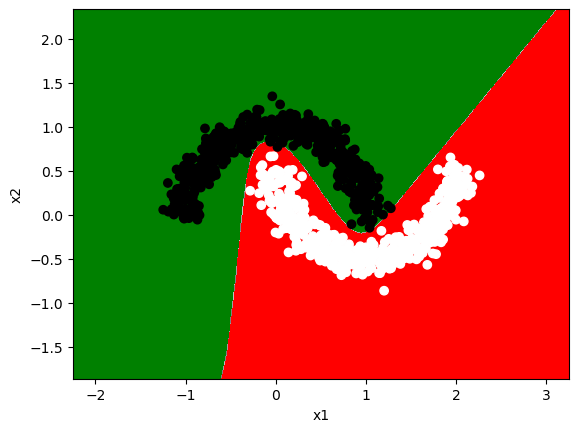

In [38]:
draw_decision_boundary(tanh_tanh_online_mode_Fixedlearning, X, y)
print(f"Accuracy = {get_accurecy(tanh_tanh_online_mode_Fixedlearning,x_test,y_test)}")

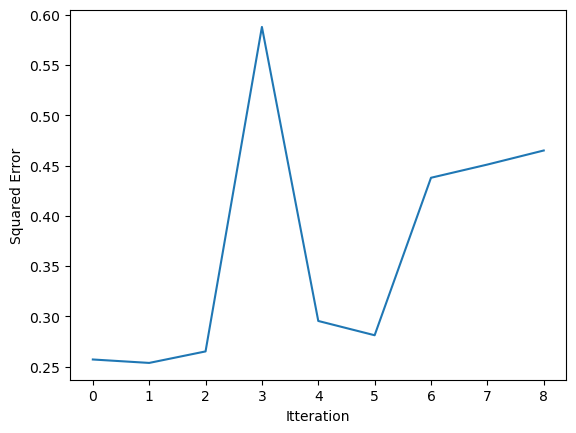

In [35]:
tanh_tanh_online_mode_Adaptivelearning = create_nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=100,
                                         act_hide='tanh',act_out='tanh',mode='online',print_cost=False,
                                         learning_rate = 0.4, reduction_factor = 0.8)

Accuracy = 1.0


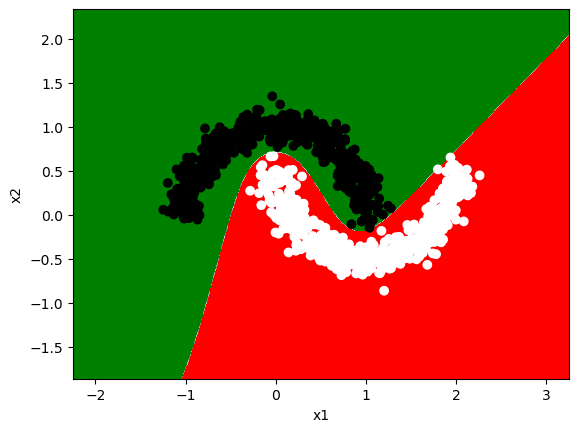

In [36]:
draw_decision_boundary(tanh_tanh_online_mode_Adaptivelearning, X, y)
print(f"Accuracy = {get_accurecy(tanh_tanh_online_mode_Adaptivelearning,x_test,y_test)}")

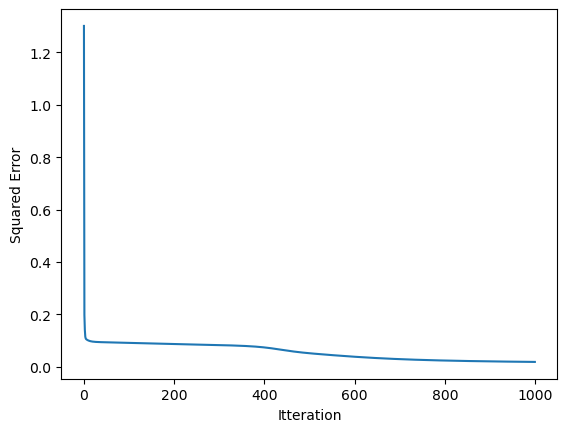

In [33]:
tanh_tanh_batch_mode_Fixedlearning = create_nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=1000,
                                     act_hide='tanh',act_out='tanh',mode='batch',print_cost=False ,
                                     learning_rate=0.7)

Accuracy = 0.99


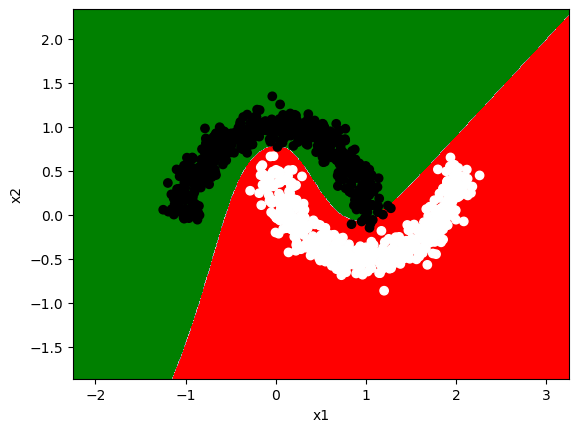

In [34]:
draw_decision_boundary(tanh_tanh_batch_mode_Fixedlearning, X, y)
print(f"Accuracy = {get_accurecy(tanh_tanh_batch_mode_Fixedlearning,x_test,y_test)}")

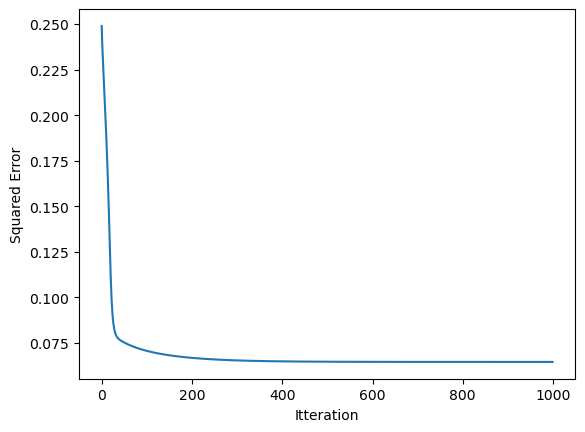

In [31]:
tanh_tanh_batch_mode_Adaptivelearning = create_nn_model(x_train, y_train,nerun_hide=8,nerun_out=1,epochs=1000,
                                        act_hide='tanh',act_out='tanh',mode='batch',print_cost=False ,
                                        learning_rate=1,reduction_factor = 0.99)

Accuracy = 0.9133333333333333


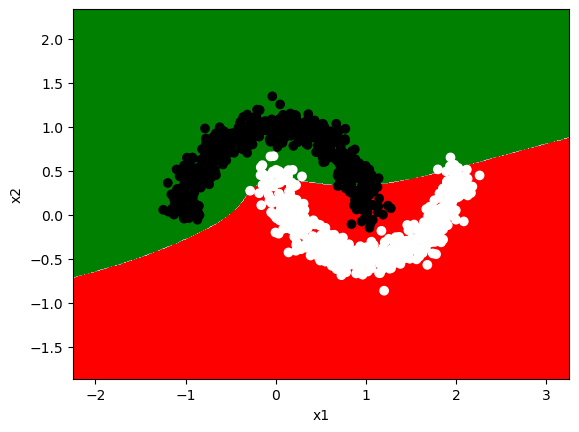

In [32]:
draw_decision_boundary(tanh_tanh_batch_mode_Adaptivelearning, X, y)
print(f"Accuracy = {get_accurecy(tanh_tanh_batch_mode_Adaptivelearning,x_test,y_test)}")

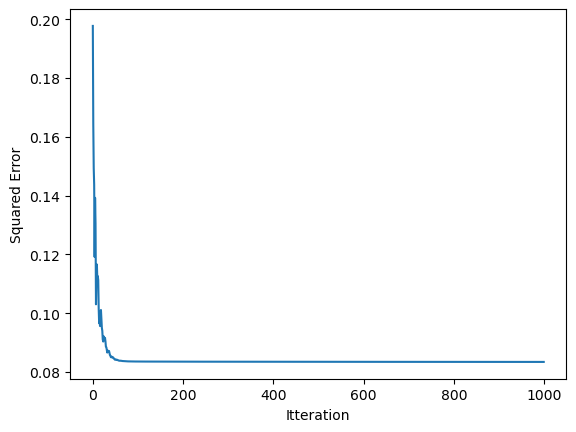

0.8833333333333333


In [29]:
tanh_tanh_batch_mode_Fixedlearning = create_nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=1000,
                                     act_hide='tanh',act_out='tanh',mode='batch',print_cost=False ,
                                     learning_rate=0.7,gama=0.9)

Accuracy = 0.8833333333333333


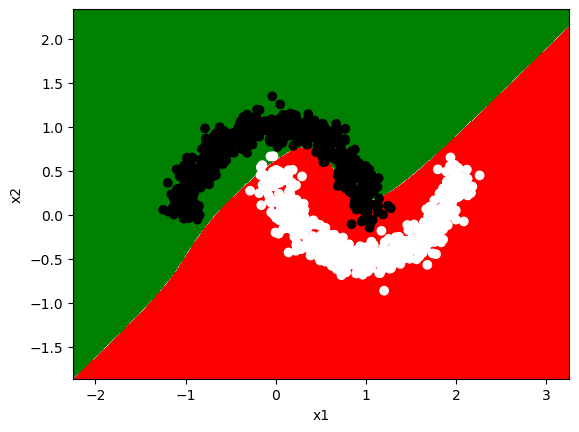

In [30]:
draw_decision_boundary(parameters_tanh_tanh_batch_learningFix, X, y)
print(f"Accuracy = {get_accurecy(tanh_tanh_batch_mode_Fixedlearning,x_test,y_test)}")